# Reanalyzing 20180123 correcting for background 

In [1]:
import numpy as np
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.insert(0, '../../../../')
import mwc.stats
import mwc.process
import mwc.bayes
import mwc.viz
colors = mwc.viz.personal_style()
%matplotlib inline

In [56]:
import imp
imp.reload(mwc.process)


<module 'mwc.process' from '../../../../mwc/process.py'>

##  The problem

Since I think the offset in my calibration factor estimate comes from temporal variation in the excitation intensity, I made some small changes to the code in SuperSegger so I could extract some information about the background fluorescence. The idea is that if I can use the information about the background fluorescence as a standard candle, I could correct for intensity fluctuations by setting the background to some mean value and correcting by that factor 

##  Processing

All of the segmentation was performed on Delbrück. I transferred all of the `clist.mat` files over to my local machine. 

In [21]:
# Define the data direcctory.
data_dir = '../../../../data/images/20180123_artemis_37C_glucose_O2_dilution/'

# Read in the growth files. 
growth_files = glob.glob('{}growth*/xy*/clist.mat'.format(data_dir))
excluded_props = ['Fluor2 mean death', 'Fluor2 bg death']
growth_df = mwc.process.parse_clists(growth_files, excluded_props=excluded_props)

# Drop the case where the background fluorescence is zero
growth_df = growth_df[growth_df['fluor1_bg_death'] > 0]

In [31]:
# Load the snap shots 
snap_folders = glob.glob('{}*snaps*'.format(data_dir))
dfs = []
for i, s in enumerate(snap_folders):
    _, strain, atc_conc = s.split('/')[-1].split('_')
    atc_conc = float(atc_conc.split('ngmL')[0])
    added_props = {'strain': strain, 'atc_conc':atc_conc}
    clists = glob.glob('{}/xy*/clist.mat'.format(s))
    df = mwc.process.parse_clists(clists, added_props=added_props)
    dfs.append(df)
snap_df = pd.concat(dfs, ignore_index=True)

## Exploratory analysis

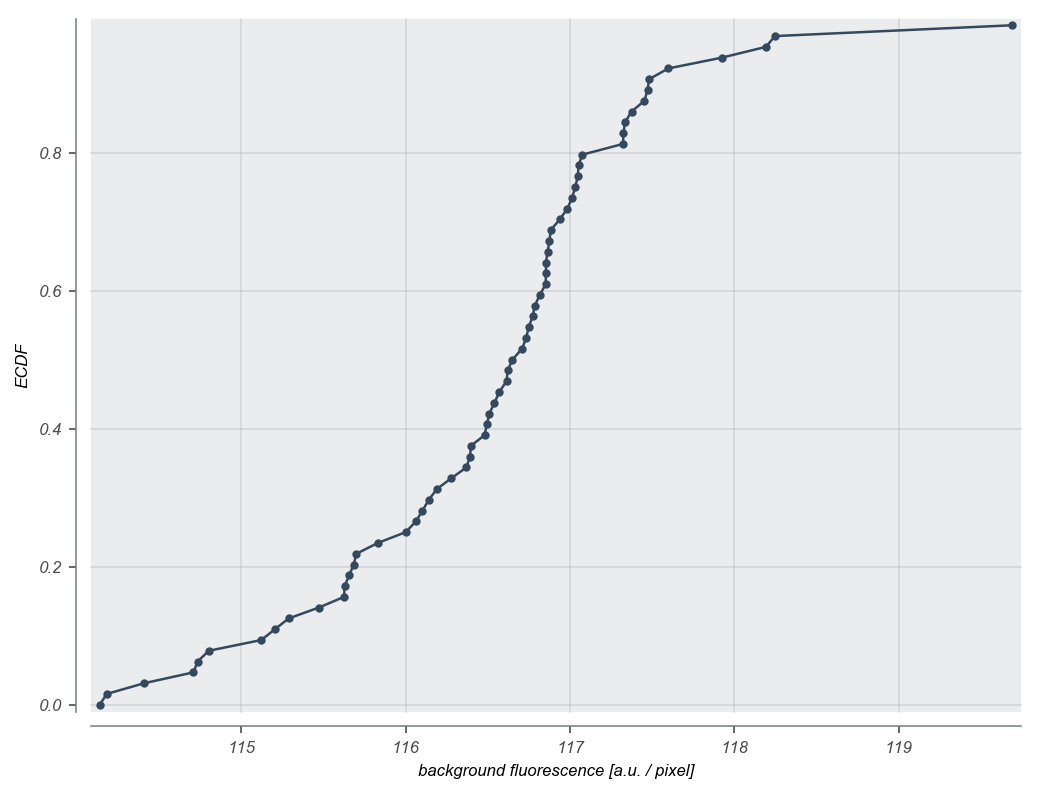

In [32]:
# Look at the variation in the background fluorescence
x, y = mwc.stats.ecdf(snap_df['fluor1_bg_death'].unique())

fig, ax = plt.subplots(1,1)
ax.set_xlabel('background fluorescence [a.u. / pixel]')
ax.set_ylabel('ECDF')
_ = ax.plot(x,y, '-o', ms=3)
mwc.viz.format_axes()

In [48]:
# Bootstrab the background values to get a measure of the mean and variance
bs_mean, bs_std = [], []
bs_reps = int(1E6)

for i in range(bs_reps):
    resampled = np.random.choice(x, replace=True, size=len(x))
    bs_mean.append(np.mean(resampled))
    bs_std.append(np.sqrt(np.var(resampled)))
    
mean_bg = np.mean(bs_mean)

In [75]:
growth_df['fluo_corr'] = growth_df['fluor1_mean_death'] / (growth_df['fluor1_bg_death'] / mean_bg)
snap_df['fluo_corr'] = snap_df['fluor1_mean_death'] / (snap_df['fluor1_bg_death'] / mean_bg)

In [76]:
mean_auto = np.mean(snap_df[snap_df['strain']=='autofluorescence']['fluo_corr'])

In [77]:
fluct_df = mwc.process.compute_fluctuations(growth_df, auto_val=mean_auto, fluo_key='fluo_corr')
orig_df = mwc.process.compute_fluctuations(growth_df, auto_val=mean_auto, fluo_key='fluor1_mean_death')

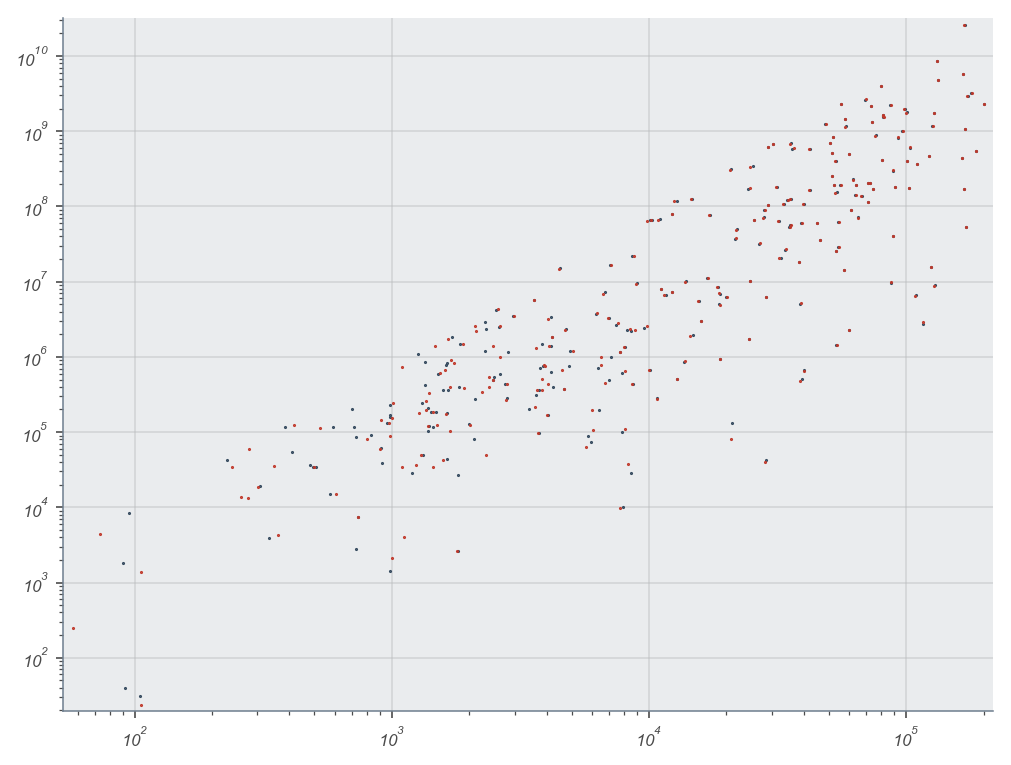

In [78]:
fig, ax = plt.subplots(1,1)
ax.loglog(fluct_df['summed'], fluct_df['fluct'], '.', ms=1)
ax.loglog(orig_df['summed'], orig_df['fluct'], '.', ms=1)



In [79]:
mwc.bayes.estimate_calibration_factor(fluct_df['I_1'], fluct_df['I_2'])

[4107.3665630319201, 312.77377419892508]

In [74]:
mwc.bayes.estimate_calibration_factor(orig_df['I_1'], orig_df['I_2'])

[4315.5044652182551, 337.38656238595325]